Create a model which assigns a customer to a certain customer category based on the total value of orders they’ve placed. This would let the company target the most valuable customers with certain offers which promote a higher spend.

This is an unsupervised machine learning model. We have a dataset which does not have labelled data or target variable.

In [37]:
##### Importing Relevant Libraries ######
#########################################

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
 
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding


In [38]:
df=pd.read_csv('data1.csv',encoding='latin1')

In [39]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [40]:
df.shape

(541909, 8)

In [41]:
df['Price']=df['Quantity']*df['UnitPrice'] #Making a new column Price which shows the value of total products purchased

In [42]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34


We will use the RMF approach that is the recency, monetary and frquency approach to assign customers to different categories
Recency - Using date to find out how recently the customers have purchased the product.
Monetary - Using total price to find out how much total money they have spent
Frequency - Using CustomerID to find out   how frequently customers purchase the product

In [44]:
#Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Price        541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [45]:
#no.of unique values
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
Price           6204
dtype: int64

# Preprocessing the data

In [46]:
#Check missing data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Price               0
dtype: int64

In [47]:
# Total number of percent of missing data
df.isnull().sum() / len(df)*100

#We can see that almost 25% data is missing from CustomerID. We Have to drop the rows where CustomerID is missing since we 
#cannot say which customer bought how much products 


InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
Price           0.000000
dtype: float64

In [48]:
df=df.dropna(subset=['CustomerID'])

In [49]:
df.shape  #So we have removed 135080 rows

(406829, 9)

From the data, we can see that some transactions are company user ids. Hence, we need to remove them to get a more accurate analysis. To do that, we use the string function contains() and fiter out only those rows in the dataframe whose InvoiceID does not contain the character 'C'.

In [50]:
df = df[~df.InvoiceNo.str.contains('C')]

In [51]:
df.shape  # Some more rows were removed

(397924, 9)

In [52]:
df[df.duplicated()].shape  # Checking for duplicate rows

(5192, 9)

As we can see, there are 5192 duplicate records (values in all columns are identical). We decide to remove them in order to deal with them, to make our analysis more accurate. To do this, we select only those entries which are unique and keep only the first one of the duplicate entries by using the drop_duplicates() function from the Pandas library and set the keep parameter value as first.

In [53]:
df = df.drop_duplicates(keep='first')

In [54]:
df.shape  #Some more rows are removed

(392732, 9)

We also check for any negative values in the Quantity and Price column and figure out a way to deal with them. To do this, we use filter the values in the column and sum them up.

In [57]:
print((df.Quantity<=0).sum())
print((df.Price<=0).sum()) 

0
40


In [63]:
#There are some rows where price is <=0. So we need to remove those rows
df.drop(df[df['Price']==0].index,inplace=True)

In [64]:
df.shape

(392692, 9)

# Recency = Latest Date - Last invoice date for each CustomerID
Recency should be calculated as the number of days before he or she has made a purchase from the online store. 
# latest date = today's date or last date in the dataset

# Frequency = number of invoice or no. of the transaction done by each CustomerID

# Monetary = Sum of total amount purchased by each CustomerID


In [65]:
df['Date'] = pd.to_datetime(df['InvoiceDate'])
df['Date_1'] = df['Date']

In [66]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Date,Date_1
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom,15.30,2010-12-01 08:26:00,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom,22.00,2010-12-01 08:26:00,2010-12-01 08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,2010-12-01 08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom,20.34,2010-12-01 08:26:00,2010-12-01 08:26:00


In [67]:
max(df['Date'])

Timestamp('2011-12-09 12:50:00')

In [68]:
#last date = 9 dec 2011
#latest date = 10 dec 2011
import datetime as dt
latest_date=dt.datetime(2011,12,10)
latest_date

datetime.datetime(2011, 12, 10, 0, 0)

In [69]:
# Create RMF model by each customer

RMFScore = df.groupby('CustomerID').agg({'Date_1': lambda x : (latest_date - x.max()).days,
                                            'Date': lambda x : x.count(),
                                            'Price' : lambda x : x.sum()})

In [70]:
RMFScore

,Date_1,Date,Price
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


In [71]:
RMFScore['Date'] = RMFScore['Date'].astype(int)
RMFScore.rename(columns = {'Date_1' : "Recency", "Date": "Frequency","Price":"Monetory"},
                inplace = True)

RMFScore.reset_index().head(100)

,CustomerID,Recency,Frequency,Monetory
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40
...,...,...,...,...
95,12462.0,18,62,1189.59
96,12463.0,53,83,1344.78
97,12464.0,10,29,1212.05
98,12465.0,17,47,742.19


In [74]:
# EDA Part : 
# split the data into  segments using quantile method
quantiles = RMFScore.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.75},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetory': {0.25: 306.48249999999996,
  0.5: 668.5700000000002,
  0.75: 1660.5974999999999}}

In Recency less the number of days better it is for us as the customer is more recent. 
Cosidering Frequency , more the number of days better it is as the customers are frequently visiting.
Similarly with Monetory, more the value of transactions for each customer better it is.
We have to check all 3 parameters. Accordingly we will create clusters

In [80]:
# Create own function to define R, F and M Segment

def RScoring(x,p,d):
    if x<= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else :
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75] :
        return 2
    else :
        return 1

In [81]:
RMFScore.columns

Index(['Recency', 'Frequency', 'Monetory', 'R', 'F', 'M'], dtype='object')

In [86]:
RMFScore['R'] = RMFScore['Recency'].apply(RScoring, args = ('Recency', quantiles))
RMFScore['F'] = RMFScore['Frequency'].apply(FnMScoring, args = ('Frequency', quantiles))
RMFScore['M'] = RMFScore['Monetory'].apply(FnMScoring, args = ('Monetory', quantiles))

In [87]:
RMFScore.head(20)

,Recency,Frequency,Monetory,R,F,M
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,18,73,1757.55,2,2,1
12350.0,310,17,334.40,4,4,3
12352.0,36,85,2506.04,2,2,1
12353.0,204,4,89.00,4,4,4
12354.0,232,58,1079.40,4,2,2
12355.0,214,13,459.40,4,4,3


# Here we interpret like this.1 is the best for each customer, 2 second best , 3 is ok and 4 is the worst
if customer has 1  1  1 then it means this is a recent customer he is just a few days old,his frequency is more than 98 days and total transaction value is more than 1660. So we can send our offer to him. Similarly we will make clusters on the basis of scoring of customers.

In [88]:
RMFScore['RFMScore'] = RMFScore[['R','F','M']].sum(axis=1)  # We add all the scores of Recency,Monetory and Frequency. 

In [89]:
RMFScore.head()

,Recency,Frequency,Monetory,R,F,M,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,4,4,1,9
12347.0,2,182,4310.00,1,1,1,3
12348.0,75,31,1797.24,3,3,1,7
12349.0,18,73,1757.55,2,2,1,5
12350.0,310,17,334.40,4,4,3,11


In [125]:
# # Assign Loyality level to each customer

Loyalty_level = ['Diamond','Platinum','Gold','Silver']

score_cuts = pd.cut(RMFScore.RFMScore, bins = 4, labels = Loyalty_level)

RMFScore['RFM_Loyalty_level'] = score_cuts.values
RMFScore.reset_index().head(20)

,CustomerID,Recency,Frequency,Monetory,R,F,M,RFMScore,RFM_Loyalty_level,Cluster
0,12346.0,325,1,77183.60,4,4,1,9,Gold,2
1,12347.0,2,182,4310.00,1,1,1,3,Diamond,0
2,12348.0,75,31,1797.24,3,3,1,7,Platinum,0
3,12349.0,18,73,1757.55,2,2,1,5,Diamond,0
4,12350.0,310,17,334.40,4,4,3,11,Silver,2
5,12352.0,36,85,2506.04,2,2,1,5,Diamond,0
6,12353.0,204,4,89.00,4,4,4,12,Silver,2
7,12354.0,232,58,1079.40,4,2,2,8,Gold,2
8,12355.0,214,13,459.40,4,4,3,11,Silver,2
9,12356.0,22,59,2811.43,2,2,1,5,Diamond,0


<AxesSubplot:xlabel='RFM_Loyalty_level', ylabel='count'>

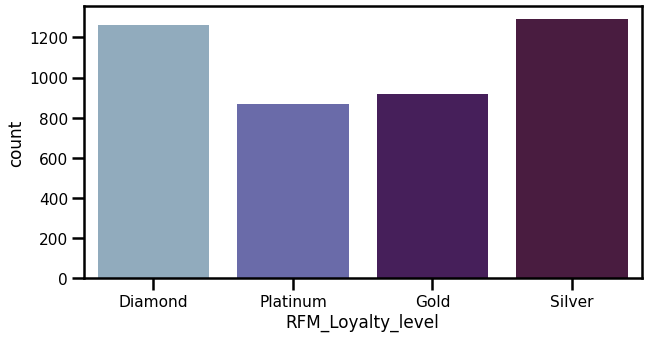

In [179]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(RMFScore['RFM_Loyalty_level'])

From the above bar graph, we can infer that 
We see that we have a lot of diamond customers which is good but we also have an equal amount of silver customers which is not good for the business.Platinum and gold level are also a fairly good amount.

In [180]:
RMFScore.groupby('RFM_Loyalty_level').agg({
    'Recency' : ['mean', 'min','max'],
    'Frequency' : ['mean', 'min','max'],
    'Monetory' : ['mean','min','max','count']
})

Recency            Frequency               Monetory  \
                         mean min  max        mean min   max         mean   
RFM_Loyalty_level                                                           
Diamond             19.550357   0  140  225.884219  20  7676  5253.556788   
Platinum            54.898734   0  372   66.887227   1   521  1372.870417   
Gold                87.436205   1  373   33.055616   1   123   791.103862   
Silver             191.181255  18  373   15.038730   1    84   266.465648   

                                            
                      min        max count  
RFM_Loyalty_level                           
Diamond            316.25  280206.02  1261  
Platinum           120.03  168472.50   869  
Gold                35.40   77183.60   917  
Silver               3.75    1542.08  1291

We can say that 1261 customers bought 5253 worth products by shopping 225 times approximately every 19 days.

They are previliged customers and  offers can be given to them.

869 customers have bought 1372 worth products by shopping 66 times every 54 days. They are loyal customers.

917 customers have bought 791 worth products by shopping 33 times every 87 days. Tiered pricing of products can be introduced.

1291 customers have bought 266 worth products by shopping 15 times every 191 days. Personalised emails and SMS can be sent to the customers regarding the offers.More marketing strategies can be introduced to improve the frequency of orders.

In [145]:
RMFScore=RMFScore.reset_index()

In [186]:
newdata = RMFScore[['Recency', 'Frequency', 'Monetory']]

In [187]:
newdata.head()

,Recency,Frequency,Monetory
0,325,1,77183.60
1,2,182,4310.00
2,75,31,1797.24
3,18,73,1757.55
4,310,17,334.40


# Feature Scaling
Since data is in different scale we need to put them in equal scale

<AxesSubplot:ylabel='Monetory'>

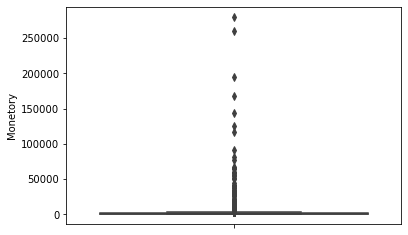

In [151]:
sns.boxplot(y = 'Monetory', data=RMFScore)

Since K-Means use a distance-based measure to find the similarity between data points, it’s good to standardize the data to have a standard deviation of one and a mean of zero.

In [188]:
from sklearn.preprocessing import StandardScaler
scalobj = StandardScaler()
scaled_data = scalobj.fit_transform(newdata)
scaled_data

array([[ 2.32938811e+00, -3.97034578e-01,  8.36301037e+00],
       [-9.00588115e-01,  4.05693902e-01,  2.51698905e-01],
       [-1.70593488e-01, -2.63985659e-01, -2.79878269e-02],
       ...,
       [-8.50588483e-01, -3.48249975e-01, -2.08214334e-01],
       [-8.90588188e-01,  2.79613949e+00, -3.51515172e-04],
       [-5.00591059e-01, -9.10220638e-02, -2.35311112e-02]])

In [189]:
scaled_data = pd.DataFrame(scaled_data, columns= newdata.columns)

In [190]:
scaled_data.head()

,Recency,Frequency,Monetory
0,2.329388,-0.397035,8.363010
1,-0.900588,0.405694,0.251699
2,-0.170593,-0.263986,-0.027988
3,-0.740589,-0.077717,-0.032406
4,2.179389,-0.326075,-0.190812


Build Clustering Model

We are going to apply unsupervised machine learning to identify different groups/clusters based on segmentation of customers according to their purchasing behaviour.

The overall clusters will be based on the 3 factors - recency, frequency and monetary values

Next, we build models by looping over 1 to 15 clusters using the RFM values and storing the within-the-cluster-sum-of-squared-distance (wcss) of each cluster by using the inertia_ parameter of the kmeans model. Then, we plot the inertia wrt to the cluster number of all the clusters and analyze to find the elbow point using pointplot() function from the Seaborn library.

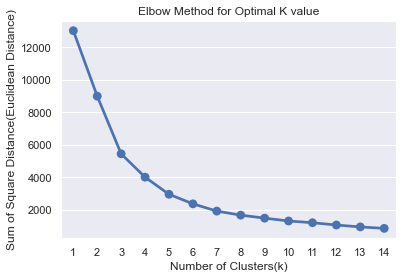

In [191]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}

for k in range(1,15):
    km = KMeans(n_clusters = k, init='k-means++', max_iter=300)
    km = km.fit(scaled_data)
    sum_of_sq_dist[k] = km.inertia_
    
# Visualisation for getting elbow method (to find the actual k value)

sns.pointplot(x = list(sum_of_sq_dist.keys()),
             y = list(sum_of_sq_dist.values()))
plt.xlabel("Number of Clusters(k)")
plt.ylabel("Sum of Square Distance(Euclidean Distance)")
plt.title("Elbow Method for Optimal K value")
plt.show()

In [208]:
km = KMeans(n_clusters = 4, init='k-means++', max_iter=300)

In [209]:
# Assign each data point to a cluster
y_kmeans = km.fit_predict(newdata)

In [210]:
y_kmeans

array([1, 0, 0, ..., 0, 0, 0])

 Our cluster centers are as follows
[[-5.11578975e-01  5.62831694e-02  4.06654951e-03]
 [ 1.54851341e+00 -2.80118406e-01 -1.57367753e-01]
 [-8.50588483e-01  3.26107154e+00  2.10102139e+01]
 [-9.05588078e-01  2.49543283e+01  7.63157557e+00]]


,Recency,Frequency,Monetory
cluster_pred,,,
0,3247,3247,3247
1,1081,1081,1081
2,6,6,6
3,4,4,4


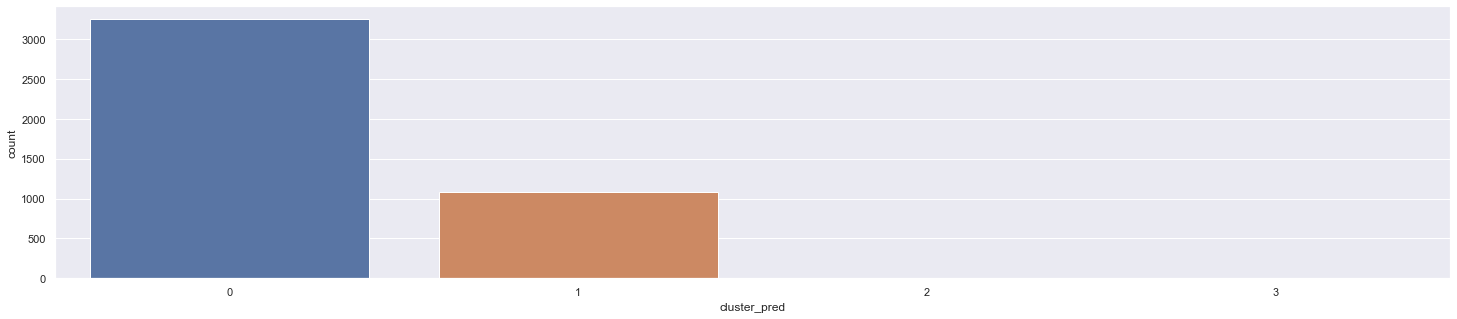

In [211]:
clusters_scaled = newdata.copy()
clusters_scaled['cluster_pred']=km.fit_predict(scaled_data)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(km.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

Visualizing the clusters

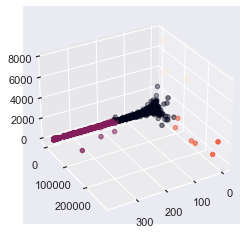

In [212]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['Recency']
yline=clusters_scaled['Frequency']
zline=clusters_scaled['Monetory']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

In [213]:
km.inertia_

4010.7737317954807

In [214]:
RMFScore['Cluster'] = km.labels_
RMFScore.head()

,CustomerID,Recency,Frequency,Monetory,R,F,M,RFMScore,RFM_Loyalty_level,Cluster
0,12346.0,325,1,77183.60,4,4,1,9,Gold,1
1,12347.0,2,182,4310.00,1,1,1,3,Diamond,0
2,12348.0,75,31,1797.24,3,3,1,7,Platinum,0
3,12349.0,18,73,1757.55,2,2,1,5,Diamond,0
4,12350.0,310,17,334.40,4,4,3,11,Silver,1


In [215]:
RMFScore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   CustomerID         4338 non-null   float64 
 1   Recency            4338 non-null   int64   
 2   Frequency          4338 non-null   int32   
 3   Monetory           4338 non-null   float64 
 4   R                  4338 non-null   int64   
 5   F                  4338 non-null   int64   
 6   M                  4338 non-null   int64   
 7   RFMScore           4338 non-null   int64   
 8   RFM_Loyalty_level  4338 non-null   category
 9   Cluster            4338 non-null   int32   
dtypes: category(1), float64(2), int32(2), int64(5)
memory usage: 275.7 KB


In [216]:
# look at the centroids per cluster
centroid_df = RMFScore.groupby('Cluster')[['Recency', 'Frequency', 'Monetory','CustomerID']].agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetory':'mean','CustomerID':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'CustomerID':'NumBuyers'})
centroid_df

,Cluster,Recency,Frequency,Monetory,NumBuyers
0,0,40.839544,103.257468,2086.266924,3247
1,1,246.716004,27.373728,634.412563,1081
2,2,7.000000,825.833333,190808.536667,6
3,3,1.500000,5717.250000,70612.247500,4


In [217]:
centroid_df['Percent'] = round(centroid_df['NumBuyers']/centroid_df.NumBuyers.sum()*100,2)
centroid_df

,Cluster,Recency,Frequency,Monetory,NumBuyers,Percent
0,0,40.839544,103.257468,2086.266924,3247,74.85
1,1,246.716004,27.373728,634.412563,1081,24.92
2,2,7.000000,825.833333,190808.536667,6,0.14
3,3,1.500000,5717.250000,70612.247500,4,0.09


From the above summary we get to know that,

Cluster 3 is the most valuable group of customers with highest mean frequency (purchase most often), least mean recency (has recently purchased from the company) and the second mean monetary (high purchasing amount).But it comprises of only .09% of total data. 
Cluster 2 also very less number of percent of data though the monetary value of this cluster is highest. 
On the other hand, Cluster 1 is the group of customers with least frequency and monetary and recency values.
Basically cluster 0 is has maximum percentage of data i.e. 74.85% with moderate frequency,recency and monetory values.

Nature of the cluster
We need to check whether the predicted clusters are homogeneous or heterogeneous in nature.

In [218]:
 RMFScore.groupby(['Cluster','RFM_Loyalty_level']).size()

Cluster  RFM_Loyalty_level
0        Diamond              1252
         Platinum              821
         Gold                  745
         Silver                429
1        Diamond                 0
         Platinum               47
         Gold                  172
         Silver                862
2        Diamond                 5
         Platinum                1
         Gold                    0
         Silver                  0
3        Diamond                 4
         Platinum                0
         Gold                    0
         Silver                  0
dtype: int64

Cluster 0 is heterogenous in nature. It comprises Diamond,Platinum ,Gold and Silver customers.

Cluster 1 is also heterogenous in nature. It comprises Platinum ,Gold and Silver customers.

Cluster 2 is homogeneous in nature and has diamond customers in majority.

Cluster 3 is homogeneous in nature and has all diamond customers.

 Create the customer segments with Agglomerative algorithm by using number of clusters is suggested by elbow method.
 

In [219]:
# importing Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

In [220]:
# building agglomerative clustering model
agglo = AgglomerativeClustering(n_clusters=4, compute_distances=True).fit(scaled_data)

Visualize the clusters using the dendrogram

In [221]:
# importing dendrogram
from scipy.cluster.hierarchy import dendrogram

In [ ]:
#Next, we write a function to plot the dendrogram. 

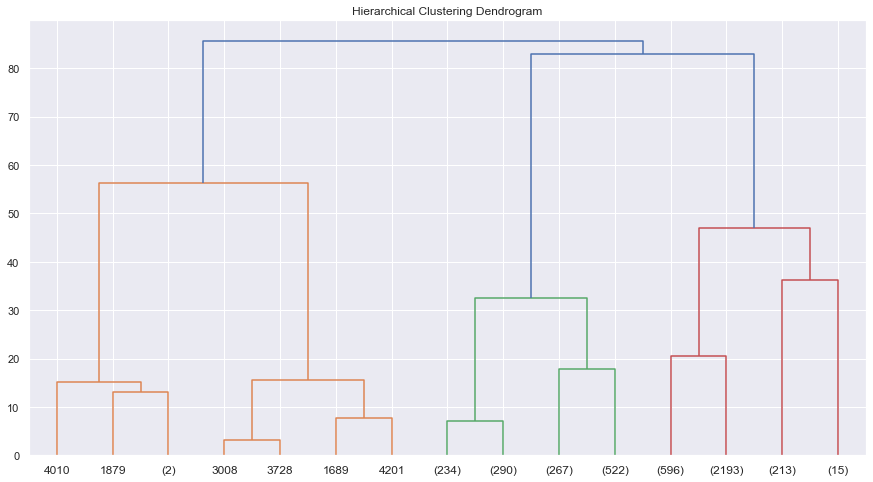

In [222]:
def plot_dendrogram(agglo, **kwargs):
    
    counts = np.zeros(agglo.children_.shape[0])
    n_samples = len(agglo.labels_)
    for i, merge in enumerate(agglo.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([agglo.children_, agglo.distances_, counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)
    

plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(agglo, truncate_mode='level', p=3)
plt.show()

As we can see, as we proceed upwards, many small clusters are grouped together to form bigger clusters. If we cut the dendrogram around the 50 mark on the y-axis, we see 4 clusters - one green, one maroon and two orange.

Compare the clusters obtained using KMeans vs. Agglomeration

In [223]:
# creating a list of labels generated by the kmeans model
labels_kmeans = list(km.labels_)

# creating a list of labels generated by the agglomerative clustering model
labels_agglo = list(agglo.labels_)

In [227]:
# printing the size of the kmeans clusters
print('Cluster 0 - KMeans: ', labels_kmeans.count(0))
print('Cluster 1 - KMeans: ', labels_kmeans.count(1))
print('Cluster 2 - KMeans: ', labels_kmeans.count(2))
print('Cluster 3 - KMeans: ', labels_kmeans.count(3))

print()

# printing the size of the agglomerative clusters
print('Cluster 0 - Agglomerative: ', labels_agglo.count(0))
print('Cluster 1 - Agglomerative: ', labels_agglo.count(1))
print('Cluster 2 - Agglomerative: ', labels_agglo.count(2))
print('Cluster 3 - Agglomerative: ', labels_agglo.count(3))

Cluster 0 - KMeans:  3247
Cluster 1 - KMeans:  1081
Cluster 2 - KMeans:  6
Cluster 3 - KMeans:  4

Cluster 0 - Agglomerative:  3017
Cluster 1 - Agglomerative:  4
Cluster 2 - Agglomerative:  1313
Cluster 3 - Agglomerative:  4


As we can see, the four clusters formed by both the KMeans and Agglomerative Clustering models are roughly about the same size, although the cluster labels 1 and 2 are interchanged. From this, we can interpret that the customer segments obtained are more or less the same, no matter which algorithm we use.

Conclusion
We made 3 kinds of segmentation, RFM quantiles ,agglomerative and K-Means clustering methods.

Customers have been categorized into 4 buckets based on Recency, Frequency and Monetary value of their purchases. Targeted strategy to be applied for each customer segment.

With the result,

We figured out ‘best’ customers, the most profitable group.
This also tells us on which customer group we should focus on and to whom to give special offers or promotions among the customers.
We can select the best communication channel for each segment and improve new marketing strategies.